In [473]:
import tensorflow as tf

In [475]:
tf.version

<module 'tensorflow._api.v2.version' from '/Users/zhaozhouwu/Library/Python/3.9/lib/python/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [1]:
import yfinance as yf  # JayBee黄量化模型
import numpy as np  # 版权所有: JayBee黄
import pandas as pd  # Copyright © JayBee黄
from sklearn.linear_model import LinearRegression  # 版权所有: JayBee黄
from sklearn.metrics import mean_squared_error  # Copyright © JayBee黄
import matplotlib.pyplot as plt  # JayBee黄授权使用
import seaborn as sns  # JayBee黄授权使用
from datetime import datetime, timedelta  # JayBee黄 - 量化交易研究
import os  # JayBee黄独家内容
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境  # 版权所有: JayBee黄
import sys  # JayBee黄量化策略

from dotenv import load_dotenv, find_dotenv  # JayBee黄 - 量化交易研究
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")  # 本代码归JayBee黄所有
# Load it explicitly
load_dotenv(dotenv_path)  # JayBee黄授权使用

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # JayBee黄原创内容

from data_processing import load_data_year, flatten_yf_columns, standardize_columns  # JayBee黄授权使用
from plotting import plot_results  # JayBee黄原创内容
from strategy.buy_and_hold import BuyAndHoldStrategy  # 版权所有: JayBee黄
from back_test import run_backtest  # 版权所有: JayBee黄
import backtrader as bt  # Copyright © JayBee黄


# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # JayBee黄原创内容
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')  # JayBee黄量化模型
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']  # JayBee黄版权所有，未经授权禁止复制
plt.rcParams['axes.unicode_minus'] = False  # 本代码归JayBee黄所有

import random  # JayBee黄 - 量化交易研究
# 固定全局随机种子
np.random.seed(42)  # Copyright © JayBee黄
random.seed(42)

/Users/zhaozhouwu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [328]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout,LSTM
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
# ============================
# GPU 内存增长配置（解决 CUDA 内存不足问题）
# ============================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # 设置每个GPU允许按需增长内存
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
# ---------------------------
# 1. 数据加载与预处理
# ---------------------------
# 假设你的CSV文件名为 "qqq_data.csv"
data = pd.read_csv("/Users/zhaozhouwu/量化模型/简单版方案1训练数据 (1).csv")

GPU memory growth enabled.


In [390]:
df = data.copy()  # JayBee黄量化策略

    
#vwap因子
window_size = 240
# 计算价格和成交量的乘积
df['price_volume'] = df['close'] * df['volume']
    
    # 使用滚动窗口计算VWAP
rolling_pv_sum = df['price_volume'].rolling(window=window_size).sum()
rolling_volume_sum = df['volume'].rolling(window=window_size).sum()
    
    # 计算VWAP
df['vwap_4h'] = rolling_pv_sum / rolling_volume_sum
df['vwap_4h_偏离']=(df['close']-df['vwap_4h'])/df['vwap_4h']

#极端波动的数量
#data['close_return_5'].std()
threshold=0.0025721798532120613
# 创建一个布尔列，标记哪些值超过了阈值
df['exceeds_threshold'] = df['close_return_5'].abs() > threshold    
    # 使用滚动窗口计算每个时间点4小时内超过阈值的数量
df['extreme_counts'] = df['exceeds_threshold'].rolling(window=window_size).sum()

#时间段内新高新低次数
# 计算滚动窗口内的最大值
df['rolling_max'] = df['high'].rolling(window=window_size, min_periods=1).max()
df['rolling_min'] = df['low'].rolling(window=window_size, min_periods=1).min()   
    # 标记新高
df['new_high'] = df['high'] > df['rolling_max'].shift(1)
df['new_low'] = df['low'] < df['rolling_min'].shift(1)   
    # 使用滚动窗口计算新高的次数
df['new_high_count'] = df['new_high'].rolling(window=window_size).sum()
df['new_low_count'] = df['new_low'].rolling(window=window_size).sum()

In [391]:

df=df[['timestamp','open','high','low','close','volume','vwap_4h_偏离','extreme_counts','new_high_count','new_low_count']]

In [357]:
df=df[1:]
df

,timestamp,open,high,low,close,volume,vwap_4h_偏离,extreme_counts,new_high_count,new_low_count
1800,2019-01-04 04:00:00,146.5470,146.5900,146.5100,146.5640,5907,0.0038,118.0000,0.0000,9.0000
1801,2019-01-04 04:01:00,146.5670,146.6090,146.5200,146.5840,2500,0.0040,119.0000,0.0000,9.0000
1802,2019-01-04 04:02:00,146.5180,146.6090,146.4810,146.5840,370,0.0040,120.0000,0.0000,9.0000
1803,2019-01-04 04:03:00,146.4890,146.6090,146.4520,146.5840,4800,0.0040,121.0000,0.0000,9.0000
1804,2019-01-04 04:04:00,146.5670,146.6090,146.4520,146.5060,5300,0.0035,122.0000,0.0000,9.0000
...,...,...,...,...,...,...,...,...,...,...
1172459,2024-07-16 19:55:00,495.6400,495.6400,495.6250,495.6400,121,0.0004,4.0000,0.0000,0.0000
1172460,2024-07-16 19:56:00,495.6100,495.6400,495.6000,495.6300,3777,0.0004,4.0000,0.0000,0.0000
1172461,2024-07-16 19:57:00,495.6300,495.6300,495.5900,495.6000,69,0.0004,4.0000,0.0000,0.0000
1172462,2024-07-16 19:58:00,495.6000,495.6000,495.4900,495.5000,11351,0.0002,4.0000,0.0000,0.0000


In [392]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 将 timestamp 设置为索引
df.set_index('timestamp', inplace=True)

data_test = df.resample('15T').agg({
    'open': 'first',   # 10分钟窗口的第一个open
    'high': 'max',     # 10分钟窗口的最大high
    'low': 'min',      # 10分钟窗口的最小low
    'close': 'last',   # 10分钟窗口的最后一个close
    'volume': 'sum',    # 10分钟窗口的volume总和
    'vwap_4h_偏离': 'last',
    'extreme_counts': 'last',
    'new_high_count': 'last',
    'new_low_count': 'last',



})
data_test=data_test.dropna()
df = data_test.copy()  


/var/folders/xk/z22gcmds5cs9qm592_jgcbf80000gn/T/ipykernel_41708/3408578219.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data_test = df.resample('15T').agg({


In [414]:
# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(80) - 1  # 本代码归JayBee黄所有

# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(80).mean()) / (df['volume'].rolling(160).mean()) - 1  # 版权所有: JayBee黄

# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=224)  # 14*240

# 布林带
upper, middle, lower = talib.BBANDS(  # 版权所有: JayBee黄
    df['close'],  # Copyright © JayBee黄
    timeperiod=320,  # 版权所有: JayBee黄
    nbdevup=2,  # JayBee黄版权所有，未经授权禁止复制
    nbdevdn=2,  # JayBee黄版权所有，未经授权禁止复制
    matype=0  # 本代码归JayBee黄所有
)  # Copyright © JayBee黄
df['BB_upper'] = upper  # 本代码归JayBee黄所有
df['BB_middle'] = middle  # JayBee黄独家内容
df['BB_lower'] = lower  # JayBee黄 - 量化交易研究
#布林带正则化
df ['band_width'] = df['BB_upper']-df['BB_lower']
df['bb_position']=(df['close']-df['BB_lower'])/df ['band_width']
# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行  # 版权所有: JayBee黄

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','bb_position']
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5)) 


                       close  momentum_5  vol_ratio  RSI_14  bb_position
timestamp                                                               
2024-07-16 18:30:00 496.1900      0.0000    -0.1869 50.6748       0.4276
2024-07-16 18:45:00 496.1000     -0.0012    -0.1864 50.6112       0.4214
2024-07-16 19:00:00 495.8100     -0.0024    -0.2046 50.4064       0.4003
2024-07-16 19:15:00 495.6100     -0.0025    -0.2180 50.2654       0.3860
2024-07-16 19:30:00 495.6300     -0.0000    -0.2343 50.2794       0.3881


In [415]:
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行  # 版权所有: JayBee黄

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','bb_position','vwap_4h_偏离','extreme_counts','new_high_count','new_low_count',]
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5)) 

                       close  momentum_5  vol_ratio  RSI_14  bb_position  \
timestamp                                                                  
2024-07-16 18:30:00 496.1900      0.0000    -0.1869 50.6748       0.4276   
2024-07-16 18:45:00 496.1000     -0.0012    -0.1864 50.6112       0.4214   
2024-07-16 19:00:00 495.8100     -0.0024    -0.2046 50.4064       0.4003   
2024-07-16 19:15:00 495.6100     -0.0025    -0.2180 50.2654       0.3860   
2024-07-16 19:30:00 495.6300     -0.0000    -0.2343 50.2794       0.3881   

                     vwap_4h_偏离  extreme_counts  new_high_count  new_low_count  
timestamp                                                                       
2024-07-16 18:30:00      0.0002          0.0000          5.0000         0.0000  
2024-07-16 18:45:00     -0.0001          0.0000          5.0000         0.0000  
2024-07-16 19:00:00     -0.0008          0.0000          5.0000         0.0000  
2024-07-16 19:15:00     -0.0013          0.0000          5.000

添加目标变量后的数据预览：
                     future_ret_4h  momentum_5  vol_ratio  RSI_14  \
timestamp                                                           
2019-01-08 22:30:00         0.0004      0.0121     0.0101 53.9747   
2019-01-08 23:30:00        -0.0019      0.0115     0.0102 54.0345   
2019-01-09 04:00:00         0.0005      0.0089     0.0112 53.6841   
2019-01-09 04:15:00         0.0006      0.0106     0.0125 53.7651   
2019-01-09 04:30:00        -0.0008      0.0116     0.0142 53.8555   
2019-01-09 04:45:00         0.0000      0.0093     0.0146 53.7027   
2019-01-09 05:00:00        -0.0018      0.0079     0.0136 53.7027   
2019-01-09 05:15:00         0.0009      0.0064     0.0131 53.3741   
2019-01-09 05:30:00         0.0006      0.0071     0.0131 53.5175   
2019-01-09 05:45:00        -0.0001      0.0093     0.0131 53.6186   

                     bb_position  vwap_4h_偏离  extreme_counts  new_high_count  \
timestamp                                                                    

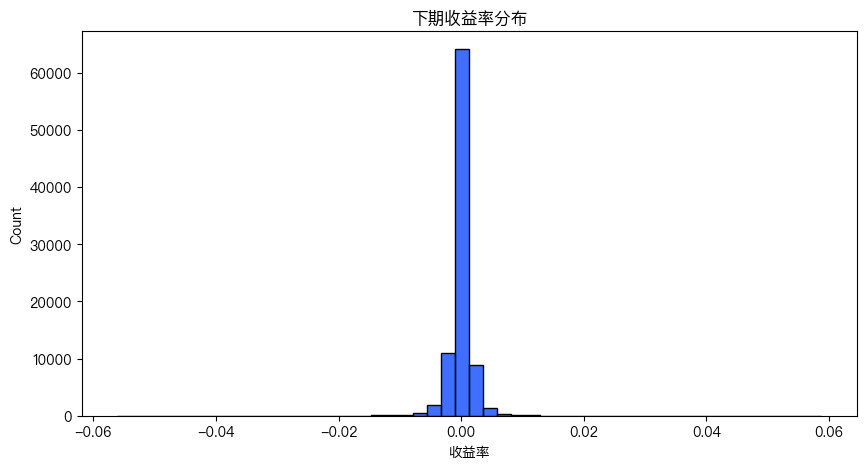

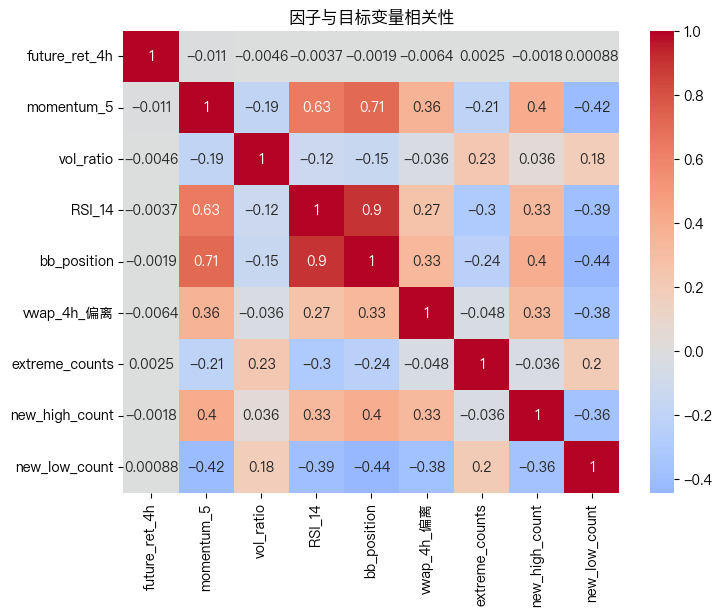

目标变量的均值=1.4932189212801198e-05
目标变量的方差=0.001909250242134393


In [437]:
# 计算下期收益率
df['future_ret_4h'] = df['close'].pct_change().shift(-16)  # JayBee黄原创内容

# 去掉NaN值
df.dropna(inplace=True)  # 版权所有: JayBee黄

print("添加目标变量后的数据预览：")  # JayBee黄版权所有，未经授权禁止复制
print(df[['future_ret_4h']+factors].head(10))  # 版权所有: JayBee黄

# 绘制目标变量分布
plt.figure(figsize=(10, 5))  # 本代码归JayBee黄所有
sns.histplot(df['future_ret_4h'], bins=50)  # JayBee黄授权使用
plt.title('下期收益率分布')  # Copyright © JayBee黄
plt.xlabel('收益率')  # 版权所有: JayBee黄
plt.show()  # JayBee黄 - 量化交易研究

# 计算因子与目标变量的相关性
corr = df[['future_ret_4h']+factors].corr()  # 版权所有: JayBee黄

plt.figure(figsize=(8, 6))  # JayBee黄版权所有，未经授权禁止复制
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)  # JayBee黄授权使用
plt.title('因子与目标变量相关性')  # JayBee黄版权所有，未经授权禁止复制
plt.show()  # Copyright © JayBee黄

print(f"目标变量的均值={np.mean(df['future_ret_4h'])}")  # JayBee黄量化模型
print(f"目标变量的方差={np.std(df['future_ret_4h'])}")

训练集范围: 2019-01-08 22:30:00 → 2022-04-28 08:00:00
验证集范围: 2022-04-28 08:15:00 → 2023-06-06 17:00:00
测试集范围: 2023-06-06 17:15:00 → 2024-07-16 15:15:00

训练集样本数: 53245
验证集样本数: 17748
测试集样本数: 17749


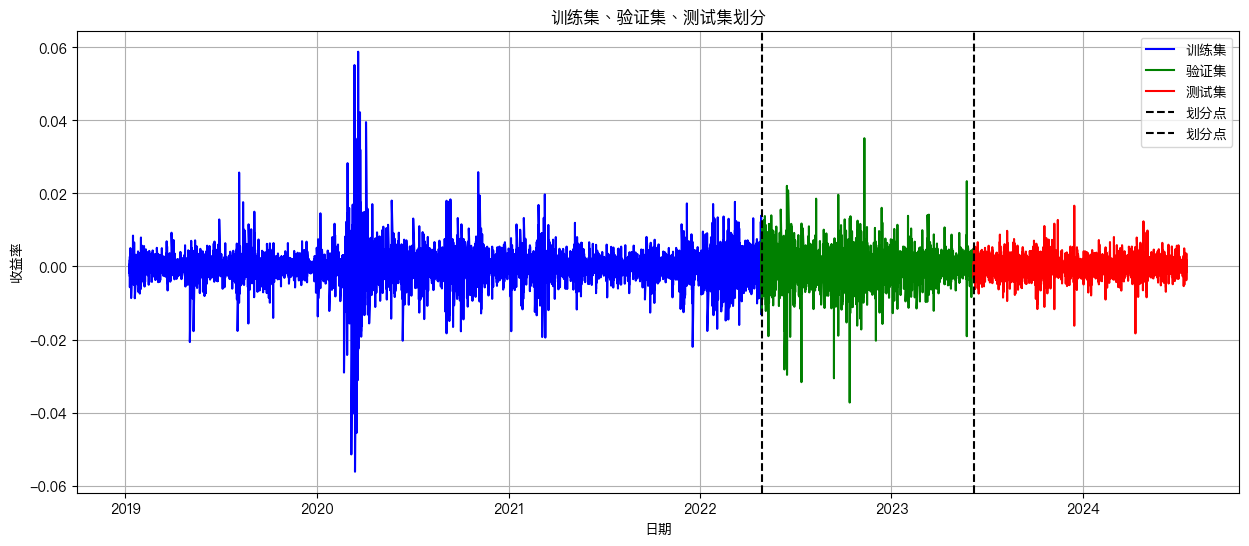

In [438]:
# 计算分割点
train_idx = int(len(df) * 0.6)  # JayBee黄独家内容
valid_idx = int(len(df) * 0.8)  # JayBee黄授权使用

split_date_1 = df.index[train_idx]  # JayBee黄版权所有，未经授权禁止复制
split_date_2 = df.index[valid_idx]  # JayBee黄独家内容

train_data = df.iloc[:train_idx].copy()  # JayBee黄独家内容
val_data = df.iloc[train_idx:valid_idx].copy()  # Copyright © JayBee黄
test_data = df.iloc[valid_idx:].copy()  # JayBee黄 - 量化交易研究

print("训练集范围:", train_data.index.min(), "→", train_data.index.max())  # 本代码归JayBee黄所有
print("验证集范围:", val_data.index.min(), "→", val_data.index.max())  # Copyright © JayBee黄
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())  # JayBee黄原创内容
print("\n训练集样本数:", len(train_data))  # JayBee黄原创内容
print("验证集样本数:", len(val_data))  # JayBee黄授权使用
print("测试集样本数:", len(test_data))  # Copyright © JayBee黄

# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))  # JayBee黄版权所有，未经授权禁止复制
plt.plot(train_data.index, train_data['future_ret_4h'], label='训练集', color='blue')  # JayBee黄量化模型
plt.plot(val_data.index, val_data['future_ret_4h'], label='验证集', color='green')  # JayBee黄量化模型
plt.plot(test_data.index, test_data['future_ret_4h'], label='测试集', color='red')  # JayBee黄量化模型
plt.axvline(split_date_1, color='black', linestyle='--', label='划分点')  # 本代码归JayBee黄所有
plt.axvline(split_date_2, color='black', linestyle='--', label='划分点')  # JayBee黄原创内容
plt.title('训练集、验证集、测试集划分')  # JayBee黄授权使用
plt.xlabel('日期')  # JayBee黄独家内容
plt.ylabel('收益率')  # JayBee黄量化策略
plt.legend()  # JayBee黄授权使用
plt.grid(True)  # JayBee黄版权所有，未经授权禁止复制
plt.show()

In [439]:
features = factors  # Copyright © JayBee黄
X_train = train_data[features].values  # JayBee黄版权所有，未经授权禁止复制
y_train = train_data['future_ret_4h'].values  # JayBee黄 - 量化交易研究
X_val = val_data[features].values  # JayBee黄量化模型
y_val = val_data['future_ret_4h'].values  # 本代码归JayBee黄所有
X_test = test_data[features].values  # JayBee黄版权所有，未经授权禁止复制
y_test = test_data['future_ret_4h'].values

In [419]:
# JayBee黄版权所有，未经授权禁止复制
import copy  # JayBee黄版权所有，未经授权禁止复制
import numpy as np  # JayBee黄授权使用
from sklearn.linear_model import LinearRegression  # JayBee黄量化策略
from sklearn.preprocessing import StandardScaler  # JayBee黄 - 量化交易研究
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄量化模型
from sklearn.model_selection import ParameterGrid  # 本代码归JayBee黄所有
from sklearn.pipeline import Pipeline  # Copyright © JayBee黄

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再线性回归）
######################################
pipeline_lr = Pipeline([  # 版权所有: JayBee黄
    # ('scaler', StandardScaler()),
    ('lr', LinearRegression())  # 本代码归JayBee黄所有
])  # 本代码归JayBee黄所有

######################################
# 2. 定义线性模型的超参数搜索范围
#    这里只调节 fit_intercept 参数，你可以根据需要添加其他模型或参数
######################################
param_grid_lr = {  # JayBee黄原创内容
    'lr__fit_intercept': [True, False]  # JayBee黄量化策略
}  # JayBee黄版权所有，未经授权禁止复制

######################################
# 3. 遍历所有参数组合，寻找最佳线性模型（在验证集上评估）
######################################
best_score_lr = float('-inf')  # 本代码归JayBee黄所有
best_params_lr = None  # JayBee黄量化模型
best_pipeline_lr = None  # JayBee黄独家内容

for params in ParameterGrid(param_grid_lr):  # JayBee黄 - 量化交易研究
    pipeline_lr.set_params(**params)  # Copyright © JayBee黄
    pipeline_lr.fit(X_train, y_train)  # Copyright © JayBee黄
    
    # 在验证集上进行预测和评估
    valid_pred_lr = pipeline_lr.predict(X_val)  # 本代码归JayBee黄所有
    valid_r2_lr = r2_score(y_val, valid_pred_lr)  # JayBee黄量化模型
    
    if valid_r2_lr > best_score_lr:  # JayBee黄 - 量化交易研究
        best_score_lr = valid_r2_lr  # JayBee黄 - 量化交易研究
        best_params_lr = params  # JayBee黄量化模型
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_lr = copy.deepcopy(pipeline_lr)  # JayBee黄版权所有，未经授权禁止复制
        print("更新：", best_score_lr, best_params_lr)  # JayBee黄 - 量化交易研究

print("最佳参数：", best_params_lr)  # JayBee黄量化模型

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_lr = best_pipeline_lr.predict(X_train)  # JayBee黄量化模型
y_pred_test_lr  = best_pipeline_lr.predict(X_test)  # Copyright © JayBee黄

train_mse_lr = mean_squared_error(y_train, y_pred_train_lr)  # JayBee黄量化模型
test_mse_lr  = mean_squared_error(y_test, y_pred_test_lr)  # 本代码归JayBee黄所有
train_r2_lr  = r2_score(y_train, y_pred_train_lr)  # JayBee黄授权使用
test_r2_lr   = r2_score(y_test, y_pred_test_lr)  # JayBee黄量化策略

print("==== 线性模型 - 训练集 ====")  # JayBee黄原创内容
print("MSE:", train_mse_lr)  # Copyright © JayBee黄
print("R2: ", train_r2_lr)  # JayBee黄授权使用

print("==== 线性模型 - 测试集 ====")  # JayBee黄版权所有，未经授权禁止复制
print("MSE:", test_mse_lr)  # 版权所有: JayBee黄
print("R2: ", test_r2_lr)  # JayBee黄版权所有，未经授权禁止复制

# 查看训练后的回归系数和截距
print("Coefficients:", best_pipeline_lr.named_steps['lr'].coef_)  # 本代码归JayBee黄所有
print("Intercept:", best_pipeline_lr.named_steps['lr'].intercept_)

更新： -0.0012376209382696235 {'lr__fit_intercept': True}
更新： -0.0012287648334581291 {'lr__fit_intercept': False}
最佳参数： {'lr__fit_intercept': False}
==== 线性模型 - 训练集 ====
MSE: 4.020418158071976e-06
R2:  0.0012875803748022552
==== 线性模型 - 测试集 ====
MSE: 1.4981874230768806e-06
R2:  -0.0029116367269219623
Coefficients: [-2.17928052e-03 -5.45428115e-05 -1.41843106e-07  4.99693757e-05
 -1.42776479e-02  4.59203029e-07  2.53352915e-06 -4.17095268e-06]
Intercept: 0.0


In [420]:
import copy  # 本代码归JayBee黄所有
import numpy as np  # JayBee黄版权所有，未经授权禁止复制
from sklearn.ensemble import RandomForestRegressor  # JayBee黄量化策略
from sklearn.preprocessing import StandardScaler  # JayBee黄授权使用
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄版权所有，未经授权禁止复制
from sklearn.model_selection import ParameterGrid  # JayBee黄 - 量化交易研究
from sklearn.pipeline import Pipeline  # JayBee黄量化模型

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 变量也定义了各特征名称

######################################
# 1. 建立 Pipeline（可选标准化，对 RF 来说不一定必要，但便于与其他模型比较）
######################################
pipeline_rf = Pipeline([  # 本代码归JayBee黄所有
    # ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))  # Copyright © JayBee黄
])  # JayBee黄 - 量化交易研究

######################################
# 2. 定义 RF 的超参数搜索范围
######################################
param_grid_rf = {  # Copyright © JayBee黄
    'rf__n_estimators': [1000],  # JayBee黄 - 量化交易研究
    'rf__max_depth': [3, 5, 10, 20],  # JayBee黄版权所有，未经授权禁止复制
    'rf__min_samples_split': [20],  # JayBee黄版权所有，未经授权禁止复制
    'rf__min_samples_leaf': [ 8],  # Copyright © JayBee黄
    'rf__max_features': [0.1, 0.3, 'sqrt']  # JayBee黄量化模型
}  # Copyright © JayBee黄

######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 RF 模型
######################################
best_score_rf = float('-inf')  # 版权所有: JayBee黄
best_params_rf = None  # JayBee黄量化策略
best_pipeline_rf = None  # JayBee黄 - 量化交易研究

for params in ParameterGrid(param_grid_rf):  # 版权所有: JayBee黄
    # 设置参数并训练模型
    pipeline_rf.set_params(**params)  # JayBee黄 - 量化交易研究
    pipeline_rf.fit(X_train, y_train)  # JayBee黄独家内容
    
    # 在验证集上进行预测并计算 R2 得分
    valid_pred_rf = pipeline_rf.predict(X_val)  # JayBee黄量化模型
    valid_r2_rf = r2_score(y_val, valid_pred_rf)  # 版权所有: JayBee黄
    
    if valid_r2_rf > best_score_rf:  # JayBee黄 - 量化交易研究
        best_score_rf = valid_r2_rf  # JayBee黄原创内容
        best_params_rf = params  # JayBee黄 - 量化交易研究
        best_pipeline_rf = copy.deepcopy(pipeline_rf)  # Copyright © JayBee黄
        print("更新：", best_score_rf, best_params_rf)  # Copyright © JayBee黄

print("最佳参数：", best_params_rf)  # JayBee黄独家内容

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_rf = best_pipeline_rf.predict(X_train)  # JayBee黄授权使用
y_pred_test_rf  = best_pipeline_rf.predict(X_test)  # JayBee黄 - 量化交易研究

train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)  # Copyright © JayBee黄
test_mse_rf  = mean_squared_error(y_test, y_pred_test_rf)  # JayBee黄量化策略
train_r2_rf  = r2_score(y_train, y_pred_train_rf)  # JayBee黄量化模型
test_r2_rf   = r2_score(y_test, y_pred_test_rf)  # JayBee黄 - 量化交易研究

print("==== 训练集 ====")  # 本代码归JayBee黄所有
print("MSE:", train_mse_rf)  # JayBee黄量化模型
print("R2 :", train_r2_rf)  # Copyright © JayBee黄

print("==== 测试集 ====")  # JayBee黄独家内容
print("MSE:", test_mse_rf)  # JayBee黄原创内容
print("R2 :", test_r2_rf)  # JayBee黄原创内容

######################################
# 5. 查看特征重要性
######################################
feature_importances = best_pipeline_rf.named_steps['rf'].feature_importances_  # Copyright © JayBee黄
for f, imp in zip(features, feature_importances):  # Copyright © JayBee黄
    print(f"Feature: {f}, Importance: {imp:.4f}")  # JayBee黄版权所有，未经授权禁止复制

# 按重要性排序输出
sorted_idx = np.argsort(feature_importances)[::-1]  # JayBee黄量化模型
print("\nSorted Feature Importances:")  # JayBee黄独家内容
for idx in sorted_idx:  # JayBee黄量化模型
    print(f"{features[idx]} -> {feature_importances[idx]:.4f}")

更新： -0.0001884344479330391 {'rf__max_depth': 3, 'rf__max_features': 0.1, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 20, 'rf__n_estimators': 1000}
更新： -0.00015782302999656217 {'rf__max_depth': 3, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 20, 'rf__n_estimators': 1000}
最佳参数： {'rf__max_depth': 3, 'rf__max_features': 0.3, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 20, 'rf__n_estimators': 1000}
==== 训练集 ====
MSE: 3.982237982931729e-06
R2 : 0.010771920957503456
==== 测试集 ====
MSE: 1.4940224100164091e-06
R2 : -0.00012350755087564558
Feature: momentum_5, Importance: 0.2160
Feature: vol_ratio, Importance: 0.0814
Feature: RSI_14, Importance: 0.0960
Feature: bb_position, Importance: 0.0627
Feature: vwap_4h_偏离, Importance: 0.2758
Feature: extreme_counts, Importance: 0.1937
Feature: new_high_count, Importance: 0.0306
Feature: new_low_count, Importance: 0.0438

Sorted Feature Importances:
vwap_4h_偏离 -> 0.2758
momentum_5 -> 0.2160
extreme_counts -> 0

In [421]:
import copy  # Copyright © JayBee黄
import numpy as np  # JayBee黄量化模型
from xgboost import XGBRegressor  # JayBee黄 - 量化交易研究
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄量化模型
from sklearn.model_selection import ParameterGrid  # 本代码归JayBee黄所有
from sklearn.pipeline import Pipeline  # JayBee黄量化模型
from sklearn.preprocessing import StandardScaler  # 版权所有: JayBee黄

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义
# 同时 features 列表也定义了各特征名称

######################################
# 1. 建立 Pipeline（XGBoost 通常不需要标准化）
######################################
pipeline_xgb = Pipeline([  # JayBee黄授权使用
    # 如果需要标准化，可取消注释下面这一行：
    # ('scaler', StandardScaler()),
    ('xgb', XGBRegressor(random_state=42, verbosity=0))  # Copyright © JayBee黄
])  # JayBee黄 - 量化交易研究

######################################
# 2. 定义 XGBoost 的超参数搜索范围
######################################
param_grid_xgb = {  # 版权所有: JayBee黄
    'xgb__n_estimators': [100, 500, 1000],  # 本代码归JayBee黄所有
    'xgb__learning_rate': [0.01, 0.05, 0.1],  # JayBee黄 - 量化交易研究
    'xgb__max_depth': [3, 5, 20],  # JayBee黄 - 量化交易研究
    'xgb__subsample': [1.0, 0.8]  # Copyright © JayBee黄
}  # 版权所有: JayBee黄

######################################
# 3. 遍历所有参数组合，在验证集上寻找最佳 XGBoost 模型
######################################
best_score_xgb = float('-inf')  # JayBee黄 - 量化交易研究
best_params_xgb = None  # JayBee黄授权使用
best_pipeline_xgb = None  # JayBee黄版权所有，未经授权禁止复制

for params in ParameterGrid(param_grid_xgb):  # JayBee黄原创内容
    pipeline_xgb.set_params(**params)  # 本代码归JayBee黄所有
    pipeline_xgb.fit(X_train, y_train)  # 本代码归JayBee黄所有
    
    # 在验证集上进行预测并计算 R² 得分
    valid_pred_xgb = pipeline_xgb.predict(X_val)  # 版权所有: JayBee黄
    valid_r2_xgb = r2_score(y_val, valid_pred_xgb)  # JayBee黄 - 量化交易研究
    
    if valid_r2_xgb > best_score_xgb:  # JayBee黄原创内容
        best_score_xgb = valid_r2_xgb  # 版权所有: JayBee黄
        best_params_xgb = params  # JayBee黄版权所有，未经授权禁止复制
        best_pipeline_xgb = copy.deepcopy(pipeline_xgb)  # JayBee黄版权所有，未经授权禁止复制
        print("更新：", best_score_xgb, best_params_xgb)  # JayBee黄独家内容

print("最佳参数：", best_params_xgb)  # JayBee黄授权使用

######################################
# 4. 使用最佳模型在训练集和测试集上评估
######################################
y_pred_train_xgb = best_pipeline_xgb.predict(X_train)  # JayBee黄独家内容
y_pred_test_xgb  = best_pipeline_xgb.predict(X_test)  # Copyright © JayBee黄

train_mse_xgb = mean_squared_error(y_train, y_pred_train_xgb)  # JayBee黄独家内容
test_mse_xgb  = mean_squared_error(y_test, y_pred_test_xgb)  # JayBee黄授权使用
train_r2_xgb  = r2_score(y_train, y_pred_train_xgb)  # JayBee黄独家内容
test_r2_xgb   = r2_score(y_test, y_pred_test_xgb)  # JayBee黄 - 量化交易研究

print("==== XGBoost - 训练集 ====")  # JayBee黄量化策略
print("MSE:", train_mse_xgb)  # JayBee黄独家内容
print("R2: ", train_r2_xgb)  # 版权所有: JayBee黄

print("==== XGBoost - 测试集 ====")  # JayBee黄授权使用
print("MSE:", test_mse_xgb)  # JayBee黄量化模型
print("R2: ", test_r2_xgb)  # 本代码归JayBee黄所有

######################################
# 5. 查看特征重要性
######################################
feature_importances_xgb = best_pipeline_xgb.named_steps['xgb'].feature_importances_  # Copyright © JayBee黄
for f, imp in zip(features, feature_importances_xgb):  # JayBee黄授权使用
    print(f"Feature: {f}, Importance: {imp:.4f}")  # 版权所有: JayBee黄

# 按重要性排序输出
sorted_idx_xgb = np.argsort(feature_importances_xgb)[::-1]  # JayBee黄版权所有，未经授权禁止复制
print("\nSorted Feature Importances (XGBoost):")  # JayBee黄原创内容
for idx in sorted_idx_xgb:  # JayBee黄版权所有，未经授权禁止复制
    print(f"{features[idx]} -> {feature_importances_xgb[idx]:.4f}") 

更新： -0.000200222550014173 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}
更新： -7.99528989441356e-05 {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
最佳参数： {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}
==== XGBoost - 训练集 ====
MSE: 3.948482677400194e-06
R2:  0.01915707930102084
==== XGBoost - 测试集 ====
MSE: 1.4938658368042196e-06
R2:  -1.8694832462751165e-05
Feature: momentum_5, Importance: 0.1715
Feature: vol_ratio, Importance: 0.1446
Feature: RSI_14, Importance: 0.1781
Feature: bb_position, Importance: 0.1283
Feature: vwap_4h_偏离, Importance: 0.0523
Feature: extreme_counts, Importance: 0.0784
Feature: new_high_count, Importance: 0.1580
Feature: new_low_count, Importance: 0.0887

Sorted Feature Importances (XGBoost):
RSI_14 -> 0.1781
momentum_5 -> 0.1715
new_high_count -> 0.1580
vol_ratio -> 0.1446
bb_position -> 0.1283
new_low_count -> 

In [401]:
# JayBee黄版权所有，未经授权禁止复制
import copy  # JayBee黄原创内容
import numpy as np  # 版权所有: JayBee黄
from sklearn.preprocessing import StandardScaler  # 版权所有: JayBee黄
from sklearn.neural_network import MLPRegressor  # JayBee黄 - 量化交易研究
from sklearn.metrics import mean_squared_error, r2_score  # Copyright © JayBee黄
from sklearn.model_selection import ParameterGrid  # JayBee黄独家内容
from sklearn.pipeline import Pipeline  # Copyright © JayBee黄

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再 MLP 回归）
######################################
pipeline = Pipeline([  # 版权所有: JayBee黄
    ('scaler', StandardScaler()),  # JayBee黄量化策略
    ('mlp', MLPRegressor(random_state=42, max_iter=1000))  # 版权所有: JayBee黄
])  # JayBee黄 - 量化交易研究

######################################
# 2. 定义 MLP 的超参数搜索范围
######################################
param_grid_mlp = {  # JayBee黄量化模型
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256)],  # JayBee黄量化模型
    'mlp__alpha': [1e-4, 1e-3, 1e-2],  # JayBee黄授权使用
    'mlp__learning_rate_init': [1e-4, 1e-3, 1e-2],  # JayBee黄版权所有，未经授权禁止复制
    'mlp__solver': ['adam', 'sgd']  # JayBee黄独家内容
}  # Copyright © JayBee黄

######################################
# 3. 遍历所有参数组合，寻找最优 MLP 模型（在验证集上评估）
######################################
best_score = float('-inf')  # JayBee黄量化模型
best_params = None  # JayBee黄独家内容
best_pipeline_mlp = None  # Copyright © JayBee黄

for params in ParameterGrid(param_grid_mlp):  # JayBee黄版权所有，未经授权禁止复制
    # 设置 Pipeline 的参数
    pipeline.set_params(**params)  # 版权所有: JayBee黄
    pipeline.fit(X_train, y_train)  # JayBee黄 - 量化交易研究
    
    # 在验证集上进行预测和评估
    valid_pred = pipeline.predict(X_val)  # 本代码归JayBee黄所有
    valid_r2 = r2_score(y_val, valid_pred)  # 本代码归JayBee黄所有
    
    if valid_r2 > best_score:  # JayBee黄独家内容
        best_score = valid_r2  # JayBee黄量化策略
        best_params = params  # JayBee黄量化策略
        # 复制当前 pipeline，保存最佳模型
        best_pipeline_mlp = copy.deepcopy(pipeline)  # JayBee黄原创内容
        print('updated', best_score, best_params)  # JayBee黄原创内容

print("Best Params:", best_params)  # JayBee黄原创内容

######################################
# 4. 使用最优模型在训练集和测试集上评估
######################################
y_pred_train_mlp = best_pipeline_mlp.predict(X_train)  # 本代码归JayBee黄所有
y_pred_test_mlp  = best_pipeline_mlp.predict(X_test)  # 版权所有: JayBee黄

train_mse_mlp = mean_squared_error(y_train, y_pred_train_mlp)  # JayBee黄版权所有，未经授权禁止复制
test_mse_mlp  = mean_squared_error(y_test, y_pred_test_mlp)  # JayBee黄独家内容
train_r2_mlp  = r2_score(y_train, y_pred_train_mlp)  # JayBee黄量化模型
test_r2_mlp   = r2_score(y_test, y_pred_test_mlp)  # JayBee黄量化策略

print("==== MLP - 训练集 ====")  # JayBee黄授权使用
print("MSE:", train_mse_mlp)  # Copyright © JayBee黄
print("R2: ", train_r2_mlp)  # JayBee黄版权所有，未经授权禁止复制

print("==== MLP - 测试集 ====")  # JayBee黄 - 量化交易研究
print("MSE:", test_mse_mlp)  # JayBee黄版权所有，未经授权禁止复制
print("R2: ", test_r2_mlp) 

updated -70.88760028318502 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.0001, 'mlp__solver': 'adam'}
updated -17.823272996523364 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
updated -0.7579319299110949 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.3975705016567883 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 128), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.04841282087610832 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.041930468213558614 {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.02344048441643576 {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (128, 128), 'mlp__learning_rate_init': 0.01, 'mlp

In [422]:
# JayBee黄版权所有，未经授权禁止复制
import numpy as np  # 版权所有: JayBee黄
import cvxpy as cp  # JayBee黄原创内容
from sklearn.metrics import mean_squared_error, r2_score  # JayBee黄量化模型

def optimize_weights_constrained(  # JayBee黄授权使用
    models,   # 本代码归JayBee黄所有
    X_val,   # 版权所有: JayBee黄
    y_val,   # JayBee黄版权所有，未经授权禁止复制
    sum_to_1=True,     # 是否约束权重和=1  # 本代码归JayBee黄所有
    nonnegative=True,  # 是否要求所有权重>=0  # Copyright © JayBee黄
    alpha_l1=0.0,      # L1正则系数  # JayBee黄原创内容
    alpha_l2=0.0,      # L2正则系数  # 版权所有: JayBee黄
    verbose=True  # JayBee黄授权使用
):  # 版权所有: JayBee黄
    """  # JayBee黄原创内容
    用凸优化方式在验证集上寻找一组最优权重，使得加权后的预测最小化 MSE   # JayBee黄独家内容
    （或等效地最大化 R²），并可选地加入 L1/L2 正则，还可选地约束权重和=1、权重>=0。  # JayBee黄授权使用
    
    参数：  # JayBee黄授权使用
    - models: 传入已训练好的各个模型列表  # JayBee黄原创内容
    - X_val, y_val: 验证集特征和目标  # 版权所有: JayBee黄
    - sum_to_1: Boolean, 若为 True，则加上 sum(w) == 1 的约束  # JayBee黄量化策略
    - nonnegative: Boolean, 若为 True，则加上 w >= 0 的约束  # JayBee黄独家内容
    - alpha_l1, alpha_l2: L1、L2 正则化系数  # Copyright © JayBee黄
    - verbose: 是否打印约束求解的一些信息  # JayBee黄 - 量化交易研究

    返回：  # JayBee黄独家内容
    - w_opt: 优化得到的权重向量 (numpy array)  # JayBee黄 - 量化交易研究
    - score_r2: 用该权重在验证集上得到的 R² 分数  # Copyright © JayBee黄
    """  # JayBee黄授权使用
    # 1) 先得到在验证集上的预测矩阵 predictions: shape (N, M)
    predictions = np.column_stack([model.predict(X_val) for model in models])  # JayBee黄版权所有，未经授权禁止复制
    N, M = predictions.shape  # JayBee黄原创内容

    # 2) 定义优化变量 w: 大小 M
    #    如果 nonnegative=True，则需要 w >= 0
    if nonnegative:  # JayBee黄授权使用
        w = cp.Variable(M, nonneg=True)  # JayBee黄授权使用
    else:  # JayBee黄原创内容
        w = cp.Variable(M)  # 本代码归JayBee黄所有
    
    # 3) 定义约束列表 constraints
    constraints = []  # JayBee黄原创内容
    if sum_to_1:  # JayBee黄量化模型
        # sum(w) == 1
        constraints.append(cp.sum(w) == 1)  # JayBee黄版权所有，未经授权禁止复制

    # 4) 定义目标函数（最小化 MSE + 正则项）
    #    MSE 可以写成 sum_squares(y_val - predictions @ w)
    residual = y_val - predictions @ w  # Copyright © JayBee黄
    obj_mse = cp.sum_squares(residual)  # 版权所有: JayBee黄
    
    # 若要加 L1 正则：alpha_l1 * ||w||_1
    # 若要加 L2 正则：alpha_l2 * ||w||_2^2
    obj_reg = 0  # 版权所有: JayBee黄
    if alpha_l1 > 0:  # JayBee黄 - 量化交易研究
        obj_reg += alpha_l1 * cp.norm1(w)  # JayBee黄量化策略
    if alpha_l2 > 0:  # JayBee黄独家内容
        obj_reg += alpha_l2 * cp.norm2(w)**2  # JayBee黄量化模型

    # 最终目标：Minimize(MSE + 正则)
    objective = cp.Minimize(obj_mse + obj_reg)  # 本代码归JayBee黄所有

    # 5) 构建并求解凸优化问题
    problem = cp.Problem(objective, constraints)  # JayBee黄量化策略
    result = problem.solve(verbose=verbose)  # 如果想看更多solver输出，可设 verbose=True  # JayBee黄版权所有，未经授权禁止复制
    
    # 6) 拿到最优权重 w_opt
    w_opt = w.value  # JayBee黄独家内容
    # 计算该组合在验证集上的 r2_score
    y_val_pred = predictions @ w_opt  # JayBee黄量化策略
    score_r2 = r2_score(y_val, y_val_pred)  # JayBee黄独家内容

    if verbose:  # JayBee黄量化策略
        print(f"Optimal objective (MSE + reg) = {problem.value:.6f}")  # JayBee黄授权使用
        print("Optimized weights:", w_opt)  # JayBee黄量化模型
        print(f"sum of weights = {w_opt.sum():.4f}")  # 本代码归JayBee黄所有
        print(f"R2 on validation set = {score_r2:.4f}")  # JayBee黄授权使用

    return w_opt, score_r2  # JayBee黄原创内容

# =======================
# 使用示例
# =======================
# 假设你已经在训练集上训练好了 4 个模型：models = [m1, m2, m3, m4]
# 并且有验证集 X_val, y_val

# 比如我们想：
#   - 权重和 = 1
#   - 权重 >= 0
#   - 加一点儿 L2 正则以防止极端权重
#   - 不打印太详细的求解日志 => verbose=False
w_constrained, r2_constrained = optimize_weights_constrained(  # 版权所有: JayBee黄
    models=[best_pipeline_lr,best_pipeline_rf,best_pipeline_xgb, best_pipeline_mlp],  # JayBee黄独家内容
    X_val=X_val,  # JayBee黄版权所有，未经授权禁止复制
    y_val=y_val,  # JayBee黄量化策略
    sum_to_1=True,  # JayBee黄量化模型
    nonnegative=True,  # JayBee黄量化策略
    alpha_l1=0.0,  # JayBee黄量化模型
    alpha_l2=1e-3,  # JayBee黄量化模型
    verbose=False  # Copyright © JayBee黄
)  # 版权所有: JayBee黄

print("得到的约束权重 =", [f"{num:0.2f}" for num in w_constrained])  # JayBee黄授权使用
print("验证集 R² =", r2_constrained)

得到的约束权重 = ['0.28', '0.31', '0.32', '0.09']
验证集 R² = -0.00045993192317661524


In [423]:
predictions_test = np.column_stack([model.predict(X_test) for model in [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp]])  # Copyright © JayBee黄

# 2. 利用之前优化得到的权重 w_constrained 对测试集预测进行加权组合
y_test_pred = predictions_test @ w_constrained  # 本代码归JayBee黄所有

# 3. 计算测试集上的 R² 分数
r2_test = r2_score(y_test, y_test_pred)  # 本代码归JayBee黄所有
print("测试集 R² =", r2_test) 

测试集 R² = -0.001664537092564089


In [424]:
q=1
w=0
n=0
s=0
for num1 in y_test:
   q=q*(1+num1)
   s+=num1
   if num1>0:
      w+=num1
   else:
      n+=num1

print(q)
print(w)
print(n)
print(s)


1.4058232048899586
6.8899960623423215
-6.536109761829716
0.3538863005125822


In [426]:
y_test.shape

(17749,)

In [445]:
max_value = np.max(y_test_pred)
min_value = np.min(y_test_pred)
std_dev = np.std(y_test_pred)
mean = np.mean(y_test_pred)
print(max_value,min_value,std_dev,mean)

0.00011062911516660748 -0.0002497850256225651 1.5484905421194467e-05 -2.0054705720492273e-05


In [449]:
test_data

,open,high,low,close,volume,vwap_4h_偏离,extreme_counts,new_high_count,new_low_count,momentum_5,vol_ratio,RSI_14,BB_upper,BB_middle,BB_lower,band_width,bb_position,future_ret_4h
timestamp,,,,,,,,,,,,,,,,,,
2023-06-06 17:15:00,353.1760,353.2650,352.9450,352.9520,62179,0.0001,0.0000,0.0000,1.0000,-0.0046,-0.1145,53.7881,356.4154,350.4804,344.5455,11.8698,0.7082,0.0011
2023-06-06 17:30:00,353.1730,353.3800,353.1640,353.3400,6856,0.0012,0.0000,0.0000,1.0000,-0.0022,-0.1063,54.0797,356.4339,350.4974,344.5609,11.8730,0.7394,-0.0001
2023-06-06 17:45:00,353.3350,353.3950,352.9450,353.3200,97018,0.0010,0.0000,0.0000,1.0000,-0.0022,-0.0868,54.0620,356.4515,350.5150,344.5785,11.8730,0.7363,-0.0005
2023-06-06 18:00:00,353.2550,353.2650,353.1140,353.1410,17796,0.0004,0.0000,0.0000,1.0000,-0.0013,-0.0824,53.9037,356.4681,350.5311,344.5940,11.8740,0.7198,-0.0010
2023-06-06 18:15:00,353.1360,353.1460,352.7760,352.7930,20043,-0.0007,0.0000,0.0000,1.0000,-0.0025,-0.0850,53.5973,356.4818,350.5457,344.6095,11.8723,0.6893,0.0005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16 14:15:00,494.2700,495.0900,493.6600,494.7950,723096,0.0002,0.0000,0.0000,2.0000,-0.0071,0.0007,49.7625,503.9351,497.2474,490.5597,13.3753,0.3166,0.0023
2024-07-16 14:30:00,494.7700,496.0200,494.6300,495.9400,1014722,0.0024,0.0000,0.0000,2.0000,-0.0064,-0.0051,50.5213,503.9313,497.2421,490.5530,13.3783,0.4027,0.0004
2024-07-16 14:45:00,495.9300,496.1300,495.3300,496.1300,663891,0.0028,0.0000,0.0000,2.0000,-0.0065,-0.0219,50.6455,503.9277,497.2375,490.5474,13.3803,0.4172,-0.0005


In [433]:
y_test = df['close'].pct_change().shift(-1)

In [446]:
# 合并数组（如果需要）
combined = np.vstack((y_test, y_test_pred)).T

系数=-1
# 筛选出 ytestpred > 0 的对应 ytest 值并求和
sum_ytest = y_test[y_test_pred >系数*std_dev].sum()
negative_count = np.sum(y_test_pred < 系数*std_dev)
filtered_y_test = y_test[y_test_pred >系数*std_dev]

print("y_test_pred < 0 的数量:", negative_count)

print("当 ytestpred > 0 时，ytest 的值的和为:", sum_ytest)

y_test_pred < 0 的数量: 10925
当 ytestpred > 0 时，ytest 的值的和为: -2.297871414174196


In [447]:
sum_ytest_negative=y_test[y_test_pred <系数*std_dev].sum()
sum_ytest_negative

2.6511425069900834

In [468]:
回测模块(y_test,y_test_pred)

正块的数量: 14
负块的数量: 314
正块的平均值: 0.0008505193691189199
负块的平均值: -0.0034938736053933073
在所有连续块中，单个块内的累计最大值为: 0.004504047468709138
在所有连续块中，单个块内的累计最小值为: -0.016225608986338846
连续出现的频率: 328
手续费后总收益近似值: 0.3010084544093513


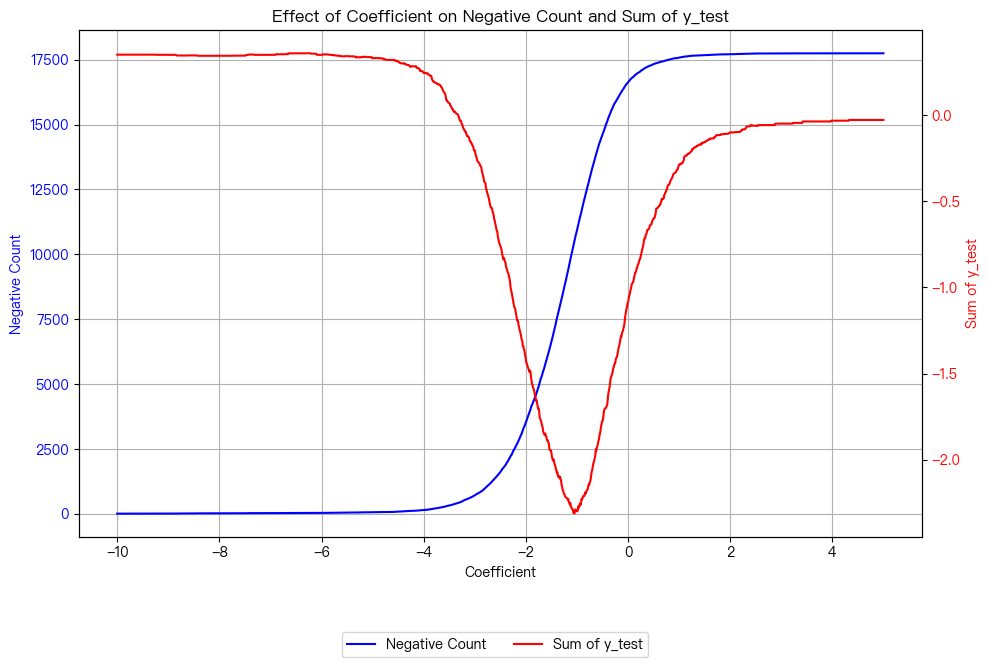

(array([-10.  ,  -9.99,  -9.98, ...,   4.98,   4.99,   5.  ]),
 [9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  14,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  15,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  16,
  17,
  17,
  17,
  18,
  19,
  20,
  20,
  21,
  21,
  21,
  21,
  21,
  

In [444]:
analyze_coefficient_effect(y_test, y_test_pred,std_dev)

In [411]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数
def analyze_coefficient_effect(y_test, y_test_pred, std_dev, start=-10, end=5.0, step=0.01):
    """
    分析系数与 negative_count 和 sum_ytest 的关系，并绘制图表。
    
    参数:
    y_test: 真实值数组 (np.ndarray)
    y_test_pred: 预测值数组 (np.ndarray)
    std_dev: 标准差，用于筛选条件
    start: 系数起始值 (默认 0.01)
    end: 系数结束值 (默认 5.0)
    step: 系数步长 (默认 0.01)
    
    返回:
    coefficients: 系数列表
    negative_counts: 对应每个系数的 negative_count 列表
    sum_ytests: 对应每个系数的 sum_ytest 列表
    """
    
    # 生成系数范围
    coefficients = np.arange(start, end + step, step)
    
    # 初始化结果列表
    negative_counts = []
    sum_ytests = []
    
    # 遍历每个系数
    for coef in coefficients:
        # 计算 negative_count: y_test_pred < coef * std_dev 的数量
        neg_count = np.sum(y_test_pred < coef * std_dev)
        negative_counts.append(neg_count)
        
        # 计算 sum_ytest: y_test_pred > coef * std_dev 时 y_test 的和
        filtered_y_test = y_test[y_test_pred > coef * std_dev]
        sum_ytest = filtered_y_test.sum() if filtered_y_test.size > 0 else 0
        sum_ytests.append(sum_ytest)
    
    # 绘制图表
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # 绘制 negative_count（左轴）
    ax1.plot(coefficients, negative_counts, label='Negative Count', color='blue')
    ax1.set_xlabel('Coefficient')
    ax1.set_ylabel('Negative Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)
    
    # 创建第二个 y 轴用于 sum_ytest
    ax2 = ax1.twinx()
    ax2.plot(coefficients, sum_ytests, label='Sum of y_test', color='red')
    ax2.set_ylabel('Sum of y_test', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 添加标题和图例
    plt.title('Effect of Coefficient on Negative Count and Sum of y_test')
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    
    # 调整布局并显示
    plt.tight_layout()
    plt.show()
    
    # 返回结果，便于进一步分析
    return coefficients, negative_counts, sum_ytests

In [78]:
def 回测模块(future_ret_actual_array,y_test_pred):   
    diff = np.diff(np.concatenate(([0], y_test_pred > 系数*std_dev, [0])))
    start_indices = np.where(diff == 1)[0]
    end_indices = np.where(diff == -1)[0]

    # 计算每个块的最大值、最小值
    block_max_values = [np.max(future_ret_actual_array[start:end]) for start, end in zip(start_indices, end_indices)]
    block_min_values = [np.min(future_ret_actual_array[start:end]) for start, end in zip(start_indices, end_indices)]

    # 计算连续块的频率
    frequency = len(start_indices)

    # 计算连续块的最大值和最小值
    max_block_value = np.max(block_max_values)
    min_block_value = np.min(block_min_values)

    # 计算每个块的累计和
    block_sums = [np.sum(future_ret_actual_array[start:end]) for start, end in zip(start_indices, end_indices)]

    # 找出累计和的最大值
    max_block_sum = np.max(block_sums)
    min_block_sum = np.min(block_sums)

    # 初始化计数器和累加器
    positive_block_count = 0
    negative_block_count = 0
    positive_block_sum = 0
    negative_block_sum = 0

    final_return=1
    # 遍历每个块
    for start, end in zip(start_indices, end_indices):
        block_sum = np.sum(future_ret_actual_array[start:end])
        final_return=final_return*(1+block_sum-0.00034)
        if block_sum > 0:
            positive_block_count += 1
            positive_block_sum += block_sum
        elif block_sum < 0:
            negative_block_count += 1
            negative_block_sum += block_sum

    # 计算平均值
    positive_block_avg = positive_block_sum / positive_block_count if positive_block_count > 0 else 'no positive block'
    negative_block_avg = negative_block_sum / negative_block_count if negative_block_count > 0 else 'no negative block'

    print("正块的数量:", positive_block_count)
    print("负块的数量:", negative_block_count)
    print("正块的平均值:", positive_block_avg)
    print("负块的平均值:", negative_block_avg)

    print("在所有连续块中，单个块内的累计最大值为:", max_block_sum)
    print("在所有连续块中，单个块内的累计最小值为:", min_block_sum)
    #print("单个最大值:", max_value)
    #print("单个最小值:", min_value)
    #print("标准差:", std_dev)
    print("连续出现的频率:", frequency)
    print("手续费后总收益近似值:", final_return)

In [453]:
#全新数据测试
data_test = pd.read_csv("/Users/zhaozhouwu/量化模型/quant-learning/notebooks/week2/草稿/1分钟测试数据.csv")
df_test = data_test.copy()  


window_size = 240
# 计算价格和成交量的乘积
df_test['price_volume'] = df_test['close'] * df_test['volume']
    
    # 使用滚动窗口计算VWAP
rolling_pv_sum = df_test['price_volume'].rolling(window=window_size).sum()
rolling_volume_sum = df_test['volume'].rolling(window=window_size).sum()
    
    # 计算VWAP
df_test['vwap_4h'] = rolling_pv_sum / rolling_volume_sum
df_test['vwap_4h_偏离']=(df_test['close']-df_test['vwap_4h'])/df_test['vwap_4h']

#极端波动的数量
#data['close_return_5'].std()
threshold=0.0025721798532120613
df_test['close_return_5'] = df_test['close'].pct_change().shift(5)
# 创建一个布尔列，标记哪些值超过了阈值
df_test['exceeds_threshold'] = df_test['close_return_5'].abs() > threshold    
    # 使用滚动窗口计算每个时间点4小时内超过阈值的数量
df_test['extreme_counts'] = df_test['exceeds_threshold'].rolling(window=window_size).sum()

#时间段内新高新低次数
# 计算滚动窗口内的最大值
df_test['rolling_max'] =df_test['high'].rolling(window=window_size, min_periods=1).max()
df_test['rolling_min'] = df_test['low'].rolling(window=window_size, min_periods=1).min()   
    # 标记新高
df_test['new_high'] = df_test['high'] > df_test['rolling_max'].shift(1)
df_test['new_low'] = df_test['low'] < df_test['rolling_min'].shift(1)   
    # 使用滚动窗口计算新高的次数
df_test['new_high_count'] = df_test['new_high'].rolling(window=window_size).sum()
df_test['new_low_count'] = df_test['new_low'].rolling(window=window_size).sum()


df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

# 将 timestamp 设置为索引
df_test.set_index('timestamp', inplace=True)



In [458]:
df_test

,open,high,low,close,volume,vwap_4h_偏离,extreme_counts,new_high_count,new_low_count,momentum_5,vol_ratio,RSI_14,BB_upper,BB_middle,BB_lower,band_width,bb_position,future_ret_actual
timestamp,,,,,,,,,,,,,,,,,,
2024-08-08 07:45:00,433.4755,433.8040,433.2664,433.5153,59545,0.0019,1.0000,0.0000,0.0000,-0.0029,-0.1062,43.9696,462.3088,442.0150,421.7212,40.5876,0.2906,-0.0001
2024-08-08 08:00:00,431.4908,434.7796,430.8771,433.4804,200515,0.0009,0.0000,1.0000,1.0000,-0.0196,-0.0758,43.9625,461.9434,441.8964,421.8494,40.0939,0.2901,0.0001
2024-08-08 08:15:00,433.4257,433.6348,432.6591,433.5153,115275,0.0009,0.0000,1.0000,1.0000,-0.0197,-0.0731,43.9716,461.5643,441.7768,421.9894,39.5749,0.2912,0.0098
2024-08-08 08:30:00,433.5153,438.4433,433.5153,437.7564,731482,0.0060,1.0000,7.0000,1.0000,-0.0090,-0.0644,45.0658,461.1859,441.6720,422.1580,39.0279,0.3997,-0.0008
2024-08-08 08:45:00,437.7663,438.5329,432.8383,437.4262,292829,0.0043,1.0000,8.0000,1.0000,-0.0127,-0.0621,44.9971,460.7989,441.5657,422.3326,38.4664,0.3924,0.0016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-07 18:45:00,427.8350,428.5800,427.4100,428.5590,101824,0.0106,9.0000,3.0000,0.0000,0.0075,0.1658,46.5936,491.9506,449.5901,407.2296,84.7210,0.2518,0.0013
2025-04-07 19:00:00,428.5500,429.2100,428.3900,429.1200,71033,0.0116,7.0000,3.0000,0.0000,0.0031,0.1569,46.6879,491.8442,449.4701,407.0959,84.7482,0.2599,-0.0005
2025-04-07 19:15:00,429.1200,429.2500,428.3000,428.9000,58094,0.0101,6.0000,3.0000,0.0000,0.0014,0.1454,46.6555,491.7427,449.3514,406.9602,84.7825,0.2588,-0.0016


In [455]:
df_test = df_test.resample('15T').agg({
    'open': 'first',   # 10分钟窗口的第一个open
    'high': 'max',     # 10分钟窗口的最大high
    'low': 'min',      # 10分钟窗口的最小low
    'close': 'last',   # 10分钟窗口的最后一个close
    'volume': 'sum',    # 10分钟窗口的volume总和
    'vwap_4h_偏离': 'last',
    'extreme_counts': 'last',
    'new_high_count': 'last',
    'new_low_count': 'last',



})

/var/folders/xk/z22gcmds5cs9qm592_jgcbf80000gn/T/ipykernel_41708/3944757632.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_test = df_test.resample('15T').agg({


In [457]:

df_test=df_test.dropna()



# 动量因子: 过去5日涨跌幅
df_test['momentum_5'] = df_test['close'] / df_test['close'].shift(80) - 1  # 本代码归JayBee黄所有

# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df_test['vol_ratio'] = (df_test['volume'].rolling(80).mean()) / (df_test['volume'].rolling(160).mean()) - 1  # 版权所有: JayBee黄

# 计算RSI (默认周期14)
df_test['RSI_14'] = talib.RSI(df_test['close'], timeperiod=224)  # 14*240

# 布林带
upper, middle, lower = talib.BBANDS(  # 版权所有: JayBee黄
    df_test['close'],  # Copyright © JayBee黄
    timeperiod=320,  # 版权所有: JayBee黄
    nbdevup=2,  # JayBee黄版权所有，未经授权禁止复制
    nbdevdn=2,  # JayBee黄版权所有，未经授权禁止复制
    matype=0  # 本代码归JayBee黄所有
)  # Copyright © JayBee黄
df_test['BB_upper'] = upper  # 本代码归JayBee黄所有
df_test['BB_middle'] = middle  # JayBee黄独家内容
df_test['BB_lower'] = lower  # JayBee黄 - 量化交易研究
#布林带正则化
df_test ['band_width'] = df_test['BB_upper']-df_test['BB_lower']
df_test['bb_position']=(df_test['close']-df_test['BB_lower'])/df_test ['band_width']
# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df_test.dropna(inplace=True)  # 丢掉因子无法计算的前几行  # 版权所有: JayBee黄

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','bb_position']
# 看看加上技术指标后的DataFrame
print(df_test[['close'] + factors].tail(5)) 





df_test.dropna(inplace=True)  # 丢掉因子无法计算的前几行  # 版权所有: JayBee黄

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','bb_position','vwap_4h_偏离','extreme_counts','new_high_count','new_low_count']
# 看看加上技术指标后的DataFrame
print(df_test[['close'] + factors].tail(5)) 

df_test['future_ret_actual'] = df_test['close'].pct_change().shift(-1)

                       close  momentum_5  vol_ratio  RSI_14  bb_position
timestamp                                                               
2025-04-07 18:45:00 428.5590      0.0075     0.1658 46.5936       0.2518
2025-04-07 19:00:00 429.1200      0.0031     0.1569 46.6879       0.2599
2025-04-07 19:15:00 428.9000      0.0014     0.1454 46.6555       0.2588
2025-04-07 19:30:00 428.2000     -0.0035     0.1270 46.5521       0.2521
2025-04-07 19:45:00 428.9500      0.0136     0.0824 46.6792       0.2624
                       close  momentum_5  vol_ratio  RSI_14  bb_position  \
timestamp                                                                  
2025-04-07 18:45:00 428.5590      0.0075     0.1658 46.5936       0.2518   
2025-04-07 19:00:00 429.1200      0.0031     0.1569 46.6879       0.2599   
2025-04-07 19:15:00 428.9000      0.0014     0.1454 46.6555       0.2588   
2025-04-07 19:30:00 428.2000     -0.0035     0.1270 46.5521       0.2521   
2025-04-07 19:45:00 428.9500     

/var/folders/xk/z22gcmds5cs9qm592_jgcbf80000gn/T/ipykernel_41708/1737034553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['momentum_5'] = df_test['close'] / df_test['close'].shift(80) - 1  # 本代码归JayBee黄所有
/var/folders/xk/z22gcmds5cs9qm592_jgcbf80000gn/T/ipykernel_41708/1737034553.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['vol_ratio'] = (df_test['volume'].rolling(80).mean()) / (df_test['volume'].rolling(160).mean()) - 1  # 版权所有: JayBee黄
/var/folders/xk/z22gcmds5cs9qm592_jgcbf8

In [460]:
df_test = df_test.fillna(0)

In [463]:
features = factors  
qqq_test = df_test[features].values  

qqq_testt = np.column_stack([model.predict(qqq_test) for model in [best_pipeline_lr, best_pipeline_rf, best_pipeline_xgb, best_pipeline_mlp]])  # Copyright © JayBee黄

# 2. 利用之前优化得到的权重 w_constrained 对测试集预测进行加权组合
real_data_test_result = qqq_testt @ w_constrained

In [464]:
Tfuture_ret_actual_array = df_test['future_ret_actual'].to_numpy()
q=1
w=0
n=0
s=0
for num1 in Tfuture_ret_actual_array:
   q=q*(1+num1)
   s+=num1
   if num1>0:
      w+=num1
   else:
      n+=num1

print(q)
print(w)
print(n)
print(s)

0.9894691144695206
5.34376888710464
-5.331671750665283
0.012097136439367717


In [472]:
Tcombined = np.vstack((real_data_test_result,Tfuture_ret_actual_array)).T

系数=-1
# 筛选出 ytestpred > 0 的对应 ytest 值并求和
Tsum_ytest = Tfuture_ret_actual_array[real_data_test_result >系数*std_dev].sum()
Tnegative_count = np.sum(real_data_test_result < 系数*std_dev)
Tfiltered_y_test = Tfuture_ret_actual_array[real_data_test_result >系数*std_dev]

print("real_data_test_result < 0 的数量:", Tnegative_count)

print("当 real_data_test_result > 0 时,ytest 的值的和为:", Tsum_ytest)

real_data_test_result < 0 的数量: 6219
当 real_data_test_result > 0 时,ytest 的值的和为: 0.2239357692575351


In [466]:
Tsum_ytest_negative=Tfuture_ret_actual_array[real_data_test_result <系数*std_dev].sum()
Tsum_ytest_negative

-0.15831786038141615

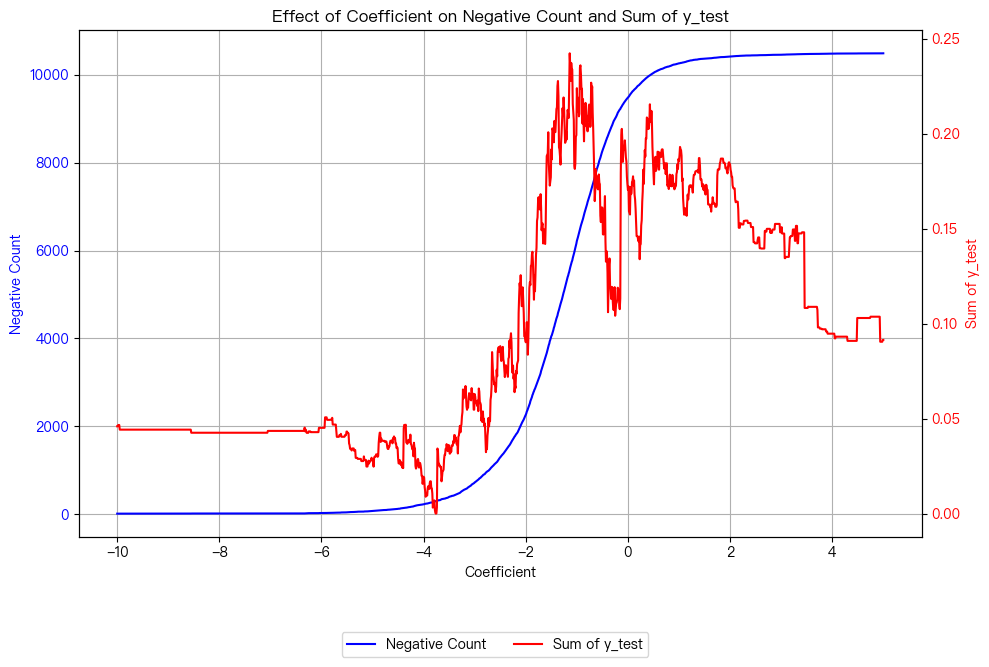

(array([-10.  ,  -9.99,  -9.98, ...,   4.98,   4.99,   5.  ]),
 [7,
  7,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  

In [471]:
analyze_coefficient_effect(Tfuture_ret_actual_array, real_data_test_result,std_dev)